# Tensorflow

In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.simplefilter('ignore', RuntimeWarning)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [4]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [5]:
data = fetch_california_housing()

We work with TF1 but ask it to emulate TF2 behavior

In [6]:
# import tensorflow.compat.v2 as tf
# tf.enable_v2_behavior()
import tensorflow as tf

In [7]:
%%capture
import tensorflow_probability as tfp
tfd = tfp.distributions

## Working with tensors

Almost exaclty like numpy arrays.`m

In [8]:
tf.constant([1., 2., 3.])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([1., 2., 3.], dtype=float32)>

In [9]:
x = tf.Variable([[1.,2.,3.], [4.,5.,6.]])

In [10]:
x.shape

TensorShape([2, 3])

In [11]:
x.dtype

tf.float32

### Conversin to numpy

In [12]:
x.numpy()

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

### Indexing

In [13]:
x[:, :2]

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1., 2.],
       [4., 5.]], dtype=float32)>

### Assignment

In [14]:
x[0,:].assign([3.,2.,1.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[3., 2., 1.],
       [4., 5., 6.]], dtype=float32)>

In [15]:
x

<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[3., 2., 1.],
       [4., 5., 6.]], dtype=float32)>

### Reductions

In [16]:
tf.reduce_mean(x, axis=0)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([3.5, 3.5, 3.5], dtype=float32)>

In [17]:
tf.reduce_sum(x, axis=1)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 6., 15.], dtype=float32)>

### Broadcasting

In [18]:
x + 10

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[13., 12., 11.],
       [14., 15., 16.]], dtype=float32)>

In [19]:
x * 10

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[30., 20., 10.],
       [40., 50., 60.]], dtype=float32)>

In [20]:
x - tf.reduce_mean(x, axis=1)[:, tf.newaxis]

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 1.,  0., -1.],
       [-1.,  0.,  1.]], dtype=float32)>

### Matrix operations

In [21]:
x @ tf.transpose(x)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[14., 28.],
       [28., 77.]], dtype=float32)>

### Ufuncs

In [22]:
tf.exp(x)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 20.085537 ,   7.389056 ,   2.7182817],
       [ 54.59815  , 148.41316  , 403.4288   ]], dtype=float32)>

In [23]:
tf.sqrt(x)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1.7320508, 1.4142135, 1.       ],
       [2.       , 2.236068 , 2.4494898]], dtype=float32)>

### Random numbers

In [24]:
X = tf.random.normal(shape=(10,4))
y = tf.random.normal(shape=(10,1))

### Linear algebra

In [25]:
tf.linalg.lstsq(X, y)

<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
array([[-0.427304  ],
       [ 0.11494821],
       [ 0.23162855],
       [ 0.62853664]], dtype=float32)>

### Vectorization

In [26]:
X = tf.random.normal(shape=(1000,10,4))
y = tf.random.normal(shape=(1000,10,1))

In [27]:
tf.linalg.lstsq(X, y)

<tf.Tensor: shape=(1000, 4, 1), dtype=float32, numpy=
array([[[-7.7759638e-02],
        [-1.3257186e-01],
        [-7.6929688e-02],
        [ 2.3807605e-01]],

       [[-2.1676989e-01],
        [ 1.1578191e-03],
        [ 1.2898314e-01],
        [ 1.9959596e-01]],

       [[-5.5951335e-02],
        [-2.3162486e-01],
        [-1.6260512e-01],
        [-2.1083586e-01]],

       ...,

       [[ 8.7220746e-01],
        [-7.2760344e-01],
        [ 1.2602654e+00],
        [-7.9936546e-01]],

       [[ 5.4767132e-01],
        [ 3.9195046e-01],
        [ 4.2830217e-01],
        [-4.3413453e-02]],

       [[-3.0089268e-01],
        [-2.1683019e-01],
        [-1.4834183e-01],
        [-1.8235873e-02]]], dtype=float32)>

### Automatic differntiation

In [28]:
def f(x,y):
    return x**2 + 2*y**2 + 3*x*y

#### Gradient

In [29]:
x, y = tf.Variable(1.0), tf.Variable(2.0)

In [30]:
with tf.GradientTape() as tape:
    z = f(x, y)

In [31]:
tape.gradient(z, [x,y])

[<tf.Tensor: shape=(), dtype=float32, numpy=8.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=11.0>]

#### Hessian

In [32]:
with tf.GradientTape(persistent=True) as H_tape:
    with tf.GradientTape() as J_tape:
        z = f(x, y)
    Js = J_tape.gradient(z, [x,y])
Hs = [H_tape.gradient(J, [x,y]) for J in Js]
del H_tape                    

In [33]:
np.array(Hs)

array([[2., 3.],
       [3., 4.]], dtype=float32)

## Keras

In [34]:
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target)

In [35]:
y_train.min(), y_train.max()

(0.14999, 5.00001)

In [36]:
scalar = StandardScaler()
X_train_s = scalar.fit_transform(X_train)
X_test_s = scalar.transform(X_test)

In [37]:
import tensorflow.keras as keras

In [38]:
Dense = keras.layers.Dense

We can consider a DL model as just a black box with a bunch of unnown parameters. For exanple, when the outoput is a Dense layer with just one node, the entire network model is just doing some form of regression. Hence we can replace a linear regression model with such a neural network model and run MCMC or VI as usual.

In [39]:
model = keras.models.Sequential([
    Dense(30, 
          activation='elu', 
          input_shape=X_train.shape[1:]),
    Dense(1)
])

In [40]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                270       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.layers

In [43]:
model.layers[0].name

'dense'

In [44]:
model.layers[0].activation

<function tensorflow.python.keras.activations.elu>

In [45]:
hist = model.fit(X_train_s, 
                 y_train,
                 epochs=10,
                 validation_split=0.2)

Train on 12384 samples, validate on 3096 samples
Epoch 1/10
12384/12384 [==============================] - 2s 145us/sample - loss: 1.9358 - mae: 1.0443 - val_loss: 0.6545 - val_mae: 0.5832
Epoch 2/10
12384/12384 [==============================] - 1s 60us/sample - loss: 0.5266 - mae: 0.5304 - val_loss: 0.5282 - val_mae: 0.5214
Epoch 3/10
12384/12384 [==============================] - 1s 59us/sample - loss: 0.4554 - mae: 0.4945 - val_loss: 0.4905 - val_mae: 0.5008
Epoch 4/10
12384/12384 [==============================] - 1s 60us/sample - loss: 0.4402 - mae: 0.4864 - val_loss: 0.4770 - val_mae: 0.4971
Epoch 5/10
12384/12384 [==============================] - 1s 58us/sample - loss: 0.4334 - mae: 0.4822 - val_loss: 0.4740 - val_mae: 0.4902
Epoch 6/10
12384/12384 [==============================] - 1s 58us/sample - loss: 0.4378 - mae: 0.4809 - val_loss: 0.4668 - val_mae: 0.4854
Epoch 7/10
12384/12384 [==============================] - 1s 59us/sample - loss: 0.4278 - mae: 0.4779 - val_loss: 0.

In [46]:
import pandas as pd

In [47]:
df = pd.DataFrame(hist.history)

In [48]:
df.head()

,loss,mae,val_loss,val_mae
0,1.935755,1.044255,0.654487,0.583205
1,0.526578,0.530396,0.528221,0.521408
2,0.455439,0.494459,0.490467,0.500771
3,0.440165,0.486384,0.476991,0.497115
4,0.433447,0.482155,0.473955,0.490190


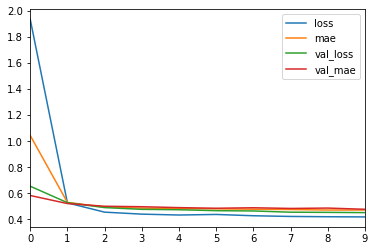

In [49]:
df.plot()
pass

In [50]:
model.evaluate(X_test_s, y_test)

5160/5160 [==============================] - 0s 33us/sample - loss: 0.4417 - mae: 0.4719


[0.4417388436868209, 0.47192544]

In [51]:
np.c_[model.predict(X_test_s[:3, :]), y_test[:3]]

array([[2.66226506, 4.889     ],
       [2.38322258, 1.746     ],
       [1.085361  , 1.533     ]])

In [52]:
model.save('housing.h5')

In [53]:
model = keras.models.load_model('housing.h5')

## Tensorflow proability

### Distributions

In [54]:
[str(x).split('.')[-1][:-2] for x in tfd.distribution.Distribution.__subclasses__()]

['Autoregressive',
 'BatchReshape',
 'Bernoulli',
 'Beta',
 'Categorical',
 'Multinomial',
 'Binomial',
 'JointDistribution',
 'JointDistribution',
 '_Cast',
 'Blockwise',
 'Cauchy',
 'Gamma',
 'Chi2',
 'TransformedDistribution',
 'Normal',
 'LKJ',
 'CholeskyLKJ',
 '_BaseDeterministic',
 '_BaseDeterministic',
 'Dirichlet',
 'DirichletMultinomial',
 'DoublesidedMaxwell',
 'Empirical',
 'FiniteDiscrete',
 'GammaGamma',
 'GaussianProcess',
 'GeneralizedPareto',
 'Geometric',
 'Uniform',
 'HalfCauchy',
 'HalfNormal',
 'HiddenMarkovModel',
 'Horseshoe',
 'Independent',
 'InverseGamma',
 'InverseGaussian',
 'Laplace',
 'LinearGaussianStateSpaceModel',
 'Logistic',
 'Mixture',
 'MixtureSameFamily',
 'MultivariateStudentTLinearOperator',
 'NegativeBinomial',
 'OneHotCategorical',
 'Pareto',
 'PERT',
 'QuantizedDistribution',
 'Poisson',
 '_TensorCoercible',
 'PixelCNN',
 'PlackettLuce',
 'PoissonLogNormalQuadratureCompound',
 'ProbitBernoulli',
 'RelaxedBernoulli',
 'ExpRelaxedOneHotCategorica

In [55]:
dist = tfd.Normal(loc=100, scale=15)

In [56]:
x = dist.sample((3,4))
x

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[112.298294,  89.107925, 117.49498 , 105.644806],
       [ 99.38011 , 121.4716  , 112.74607 , 126.83206 ],
       [112.833664, 119.85916 , 105.05743 ,  96.81615 ]], dtype=float32)>

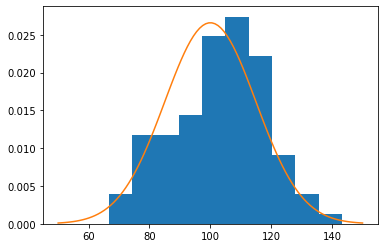

In [57]:
n = 100
xs = dist.sample(n)
plt.hist(xs, density=True)
xp = tf.linspace(50., 150., 100)
plt.plot(xp, dist.prob(xp))
pass

### Broadcasting

In [58]:
dist = tfd.Normal(loc=[3,4,5,6], scale=0.5)

In [59]:
dist.sample(5)

<tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[3.0555534, 3.8904114, 5.2794166, 5.9625177],
       [3.884369 , 5.159878 , 4.394644 , 5.358372 ],
       [3.0781407, 4.152742 , 5.883699 , 5.845205 ],
       [2.5866   , 3.4164045, 5.4926476, 5.5667934],
       [3.1870022, 4.1119504, 5.0041285, 6.1963325]], dtype=float32)>

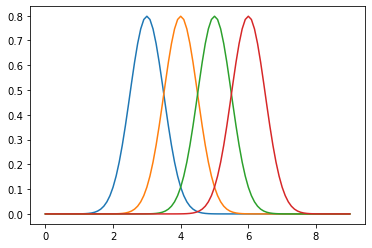

In [60]:
xp = tf.linspace(0., 9., 100)[:, tf.newaxis]
plt.plot(np.tile(xp, dist.batch_shape), dist.prob(xp))
pass

### Mixtures

In [ ]:
tfd.MixtureSameFamily?

In [61]:
gmm = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(
        probs=[0.4, 0.1, 0.2, 0.3]
    ),
    components_distribution=tfd.Normal(
      loc=[3., 4., 5., 6.],      
      scale=[0.1, 0.5, 0.5, .1])
)

In [62]:
n = 10000
xs = gmm.sample(n)

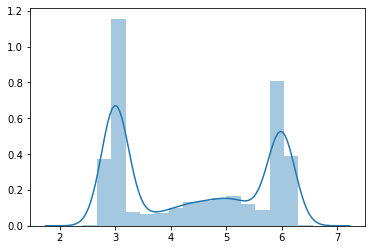

In [63]:
sns.distplot(xs)
pass

### Transformations

In [64]:
[x for x in dir(tfp.bijectors) if x[0].isupper()]

['AbsoluteValue',
 'Affine',
 'AffineLinearOperator',
 'AffineScalar',
 'AutoregressiveNetwork',
 'BatchNormalization',
 'Bijector',
 'Blockwise',
 'Chain',
 'CholeskyOuterProduct',
 'CholeskyToInvCholesky',
 'CorrelationCholesky',
 'Cumsum',
 'DiscreteCosineTransform',
 'Exp',
 'Expm1',
 'FFJORD',
 'FillScaleTriL',
 'FillTriangular',
 'GeneralizedPareto',
 'Gumbel',
 'GumbelCDF',
 'Identity',
 'Inline',
 'Invert',
 'IteratedSigmoidCentered',
 'Kumaraswamy',
 'KumaraswamyCDF',
 'Log',
 'Log1p',
 'MaskedAutoregressiveFlow',
 'MatrixInverseTriL',
 'MatvecLU',
 'NormalCDF',
 'Ordered',
 'Pad',
 'Permute',
 'PowerTransform',
 'RationalQuadraticSpline',
 'RealNVP',
 'Reciprocal',
 'Reshape',
 'Scale',
 'ScaleMatvecDiag',
 'ScaleMatvecLU',
 'ScaleMatvecLinearOperator',
 'ScaleMatvecTriL',
 'ScaleTriL',
 'Shift',
 'Sigmoid',
 'SinhArcsinh',
 'Softfloor',
 'SoftmaxCentered',
 'Softplus',
 'Softsign',
 'Square',
 'Tanh',
 'TransformDiagonal',
 'Transpose',
 'Weibull',
 'WeibullCDF']

In [65]:
lognormal = tfp.bijectors.Exp()(tfd.Normal(0, 0.5))

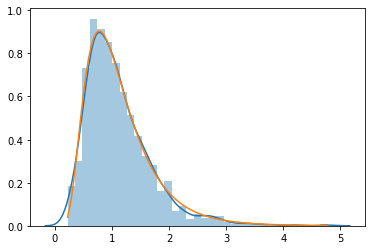

In [66]:
xs = lognormal.sample(1000)
sns.distplot(xs)
xp = np.linspace(tf.reduce_min(xs), tf.reduce_max(xs), 100)
plt.plot(xp, tfd.LogNormal(loc=0, scale=0.5).prob(xp))
pass

## Regression

In [67]:
xs = tf.Variable([0., 1., 2., 5., 6., 8.])
ys = tf.sin(xs) + tfd.Normal(loc=0, scale=0.5).sample(xs.shape[0])

In [68]:
xs.shape, ys.shape

(TensorShape([6]), TensorShape([6]))

In [69]:
xs.numpy()

array([0., 1., 2., 5., 6., 8.], dtype=float32)

In [70]:
ys.numpy()

array([ 0.01067163,  0.78099585,  0.6936413 , -0.37853056,  0.36542195,
        0.8795101 ], dtype=float32)

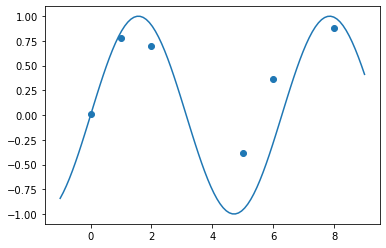

In [71]:
xp = tf.linspace(-1., 9., 100)[:, None]
plt.scatter(xs.numpy(), ys.numpy())
plt.plot(xp, tf.sin(xp))
pass

In [72]:
kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(length_scale=1.5)
reg = tfd.GaussianProcessRegressionModel(
    kernel, xp[:, tf.newaxis], xs[:, tf.newaxis], ys
)

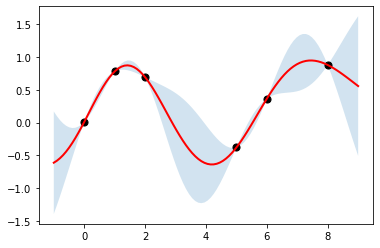

In [74]:
ub, lb = reg.mean() + [2*reg.stddev(), -2*reg.stddev()]
plt.fill_between(np.ravel(xp), np.ravel(ub), np.ravel(lb), alpha=0.2)
plt.plot(xp, reg.mean(), c='red', linewidth=2)
plt.scatter(xs[:], ys[:], s=50, c='k')
pass

### Modeling

Sampling from a normal distribuiton using HMC (prior predictive samples)

In [75]:
[x for x in dir(tfp.mcmc) if x[0].isupper()]

['CheckpointableStatesAndTrace',
 'DualAveragingStepSizeAdaptation',
 'HamiltonianMonteCarlo',
 'MetropolisAdjustedLangevinAlgorithm',
 'MetropolisHastings',
 'NoUTurnSampler',
 'RandomWalkMetropolis',
 'ReplicaExchangeMC',
 'SimpleStepSizeAdaptation',
 'SliceSampler',
 'StatesAndTrace',
 'TransformedTransitionKernel',
 'TransitionKernel',
 'UncalibratedHamiltonianMonteCarlo',
 'UncalibratedLangevin',
 'UncalibratedRandomWalk']

In [76]:
dir(tfp.vi)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_allowed_symbols',
 'amari_alpha',
 'arithmetic_geometric',
 'chi_square',
 'csiszar_vimco',
 'dual_csiszar_function',
 'fit_surrogate_posterior',
 'jeffreys',
 'jensen_shannon',
 'kl_forward',
 'kl_reverse',
 'log1p_abs',
 'modified_gan',
 'monte_carlo_variational_loss',
 'mutual_information',
 'pearson',
 'squared_hellinger',
 'symmetrized_csiszar_function',
 't_power',
 'total_variation',
 'triangular']

In [77]:
from tensorflow_probability import edward2 as ed

In [78]:
# From example in help docs

def unnormalized_log_prob(x):
    return -x - x**2.
 
# Initialize the HMC transition kernel.
num_results = int(1e2)
num_burnin_steps = int(1e2)
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_log_prob,
        num_leapfrog_steps=3,
        step_size=1.),
    num_adaptation_steps=int(num_burnin_steps * 0.8))
 
# Run the chain (with burn-in).
samples, is_accepted = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=1.,
    kernel=adaptive_hmc,
    trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)
 
sample_mean = tf.reduce_mean(samples)
sample_stddev = tf.math.reduce_std(samples)

In [79]:
sample_mean

<tf.Tensor: shape=(), dtype=float32, numpy=-0.37961948>

In [80]:
sample_stddev

<tf.Tensor: shape=(), dtype=float32, numpy=0.57268214>

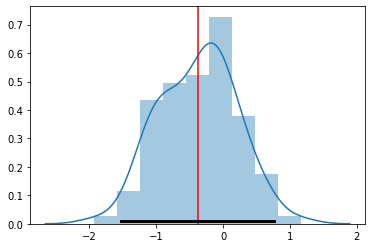

In [81]:
sns.distplot(samples)
plt.axvline(sample_mean.numpy(), c='red')
plt.plot([sample_mean - 2*sample_stddev, sample_mean + 2*sample_stddev], 
         [0.01, 0.01], c='k', linewidth=3)
pass